### 04. PyTorch Custom Datasets

we've  used some datasets with pytorch before.

But how do you get you rown data into pytorch?

 one of the ways to do is via: custom datasets.

### 0. Importing PyTorch and setting up device-agnostic code

In [ ]:
import torch
from torch import nn

torch.__version__

'2.2.1+cu121'

In [ ]:
# setting up device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


### 1. Get data

out dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training , 250 testing).

our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing).and

Why do this?

when starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how faste you can experiment.

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and suhsi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, suhsi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak and sushi data...


### 2. Becoming one with the data (data preparation and data exploration)

In [ ]:
import os
def walk_through_dir(dir_path):
  """Wlaks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza


In [ ]:
# setup train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
type(image_path)

pathlib.PosixPath

### 2.1 Visualizing and image

Let's write some code to:

1. Get all of the image paths
2. Pick a random image path using Python's rando.choice()
3. Get the image class names using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then how th eimage and print metadata

In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

In [ ]:
import random
from PIL import Image

# 1. get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. Pick a random images path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path naem (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
img.height, img.width

(512, 512)

array([[[143, 124, 146],
        [141, 122, 144],
        [149, 130, 152],
        ...,
        [143, 118, 139],
        [144, 119, 138],
        [144, 119, 138]],

       [[147, 128, 150],
        [145, 126, 148],
        [147, 128, 150],
        ...,
        [144, 119, 140],
        [145, 120, 139],
        [146, 121, 140]],

       [[139, 120, 142],
        [142, 123, 145],
        [147, 128, 150],
        ...,
        [148, 123, 144],
        [152, 127, 146],
        [157, 132, 151]],

       ...,

       [[ 85,  36,  29],
        [ 82,  33,  26],
        [ 82,  33,  26],
        ...,
        [ 84,  35,  28],
        [ 84,  35,  28],
        [ 84,  35,  28]],

       [[ 89,  39,  32],
        [ 86,  36,  29],
        [ 85,  35,  28],
        ...,
        [ 79,  29,  20],
        [ 80,  30,  21],
        [ 80,  30,  21]],

       [[ 86,  36,  29],
        [ 86,  36,  29],
        [ 85,  35,  28],
        ...,
        [ 88,  38,  29],
        [ 92,  42,  33],
        [ 94,  44,  35]]], dtype=uint8)
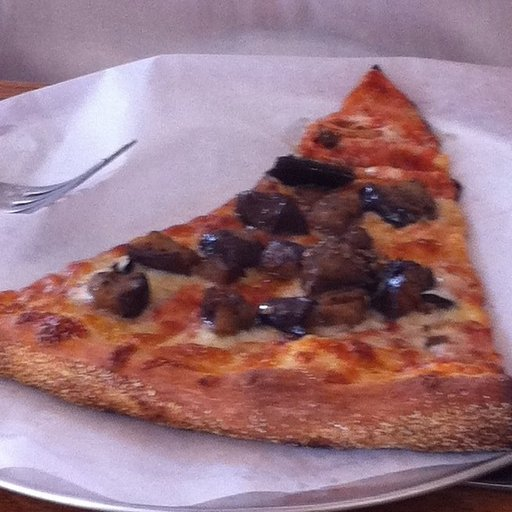

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the images into numpy arrays
img_as_array = np.asarray(img)
img_as_array

### 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in ou rcase, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [ ]:
from torch.utils.data import dataloader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help ypu get your images ready to be used with a model/perform data augmentation

In [ ]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our image to 64x64
    transforms.Resize(size = (64, 64)),
    # Flip the image randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [ ]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [ ]:
img.height

512

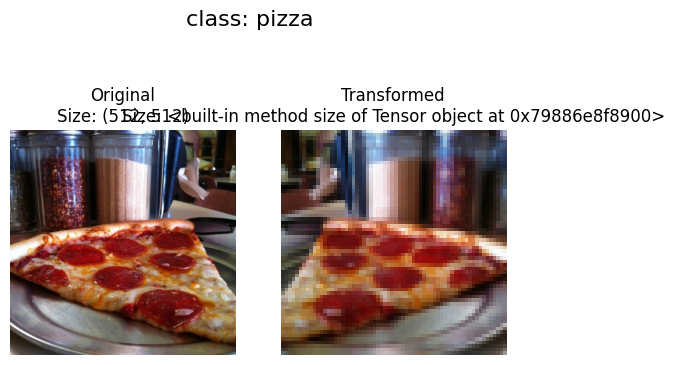

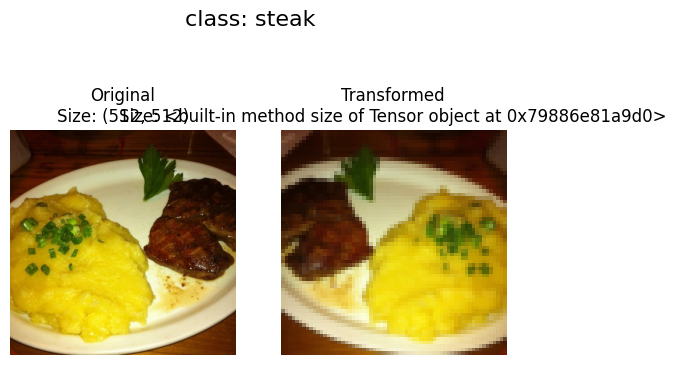

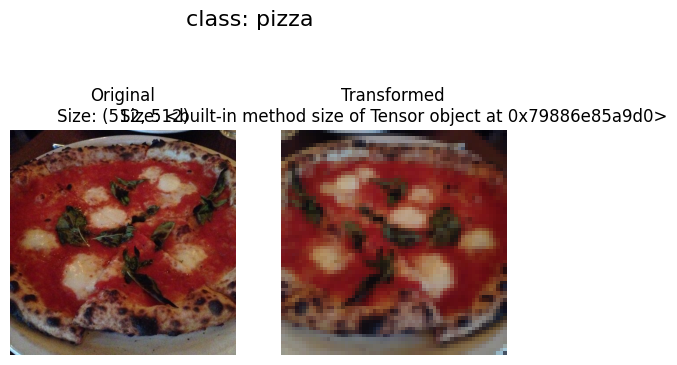

In [ ]:
def plot_transformed_images(image_paths: list, transform, n = 3, seed = None):
  """
  Selects random images from a path of images and loads/transforms them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths,k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original\nSize: {f.size}')
      ax[0].axis(False)

      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\nSize: {transformed_image.size}')
      ax[1].axis(False)

      fig.suptitle(f'class: {image_path.parent.stem}', fontsize = 16)

plot_transformed_images(image_paths = image_path_list,
                           transform = data_transform,
                            n = 3,
                            seed = None)

### 4. Option 1" loading image data using `ImageFolder`

we can load image classification data using `torchcision.datasets.ImageFolder`

In [ ]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform,
                                  target_transform = None)
test_data = datasets.ImageFolder(root = test_dir,
                                  transform = data_transform,
                                  target_transform = None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
len(train_data), len(test_data)

(225, 75)

In [ ]:
img, label = train_data[0][0], train_data[0][1]

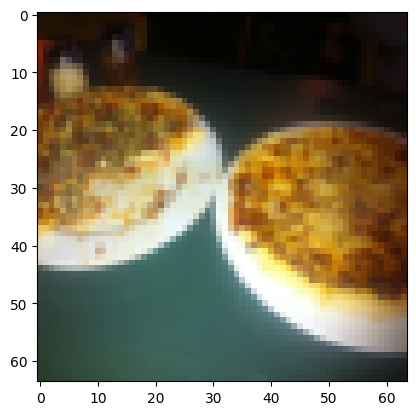

In [ ]:
# Rearrane the order dimensions
img_permute = img.permute(1,2,0)
plt.imshow(img_permute)

### 4.1 Turn loaded images into `DataLoader`

A `DataLoader` is going to help us turn our `Dataset`'s into iterable and we can customize the `batch_size` so our model can see `batch_size` images at a time'

In [ ]:
import os
os.cpu_count()

2

In [ ]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = 1,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = 1,
                             shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79886e70eec0>,
 <torch.utils.data.dataloader.DataLoader at 0x79886e8d7160>)

In [ ]:
len(train_dataloader), len(test_dataloader)

(225, 75)

### 5. Option 2: Loading Image Dtaa with a Custom `Dataset`

1. Want to be able to load images from file
2. want to be able to get class nams from the Dataset
3. Wnat to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `dataset` out of almost anything
* Not lijmited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` ofen results in us writing more code, which could prone to errors or performance issues

All custom dtasets in PyTorch. Often subclass `torch.utils.dataa.Dataset`

In [ ]:
from typing import Tuple, Dict, List
from torchvision import transforms

In [ ]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

 we want a function to:
 1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
 2. Raise an error if the class names are'nt found (if this happens, there might be something wrong with the directory structure).
 3. Turn the class names into a dict and a list and return them.

In [ ]:
# Setup path for target directory
target_directory = train_dir
print(f'target directory: {target_directory}')

# Get th eclasss names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

target directory: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [ ]:
for entry in list(os.scandir(target_directory)):
  print(f'entry: {entry} | entry.name: {entry.name}')

entry: <DirEntry 'steak'> | entry.name: steak
entry: <DirEntry 'sushi'> | entry.name: sushi
entry: <DirEntry 'pizza'> | entry.name: pizza


In [ ]:
temp = sorted([a for a in list(os.listdir(target_directory))])
temp
# for a in list(os.listdir(target_directory)):
#   print(a)

['pizza', 'steak', 'sushi']

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds th eclass folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}.... please check file structure.")

  # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:
1. Subclass `torch.utils.data.Dataset`
2. Init out subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data
3. Create several attributes:
  * paths - paths of our images
  * transform - the transform we'd like to use
  * classes - a list of th etarget classes
  * class_to_idx - a dict of the target classes mapped to integer labels
4. create a function to `load_images()`, this function will open an image
5. overwrite the `__len__()` method to return the length of our dataset
6. Overwrite the `__getitem__()` method to return a given sampple when passes an index

In [ ]:
import pathlib
pathlib.Path(train_dir)

PosixPath('data/pizza_steak_sushi/train')

In [ ]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1 Subclass torch.utils.dataa.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self, targ_dir: str, transform = None):
    # 3. for __len__() function to return the length, we need all the available files at the location
    # therefore we store all the paths in `self.paths`
    self.paths = list(pathlib.Path(targ_dir).glod('*/*.jpg'))
    self.classes, self.class_to_idx = find_classes(targ_dir)
    self.transform = transform

  # 2. Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of samples"
    # store all the available paths in a variable and return the length of the variable
    return len(self.paths)

  # 4. Overwrite __getitem__( method to return a particular sample)
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample od data, data and label (X, y)."
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]